In [1]:
### If save data:
save_data = False

if save_data:
  def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/
  save_dir = "Figs/"
  ensure_dir(save_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize
import scipy.special
import scipy.stats
import math
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

!pip install -q git+https://github.com/Pehlevan-Group/kernel-generalization
from kernel_generalization import kernel_simulation as ker_sim
from kernel_generalization import kernel_spectrum as ker_spec
from kernel_generalization import kernel_regression as ker_reg

!git clone https://github.com/Pehlevan-Group/kernel-generalization.git
parent = os.path.join(os.getcwd(),'kernel-generalization/PrecomputedData/')
dir_fixed_noise = parent + 'SynthDataGaussianRBF/error_rbf_prl_fixed_noise.npz'
dir_fixed_alpha = parent + 'SynthDataGaussianRBF/error_rbf_prl_fixed_alpha.npz'
dir_noiseless = parent + 'SynthDataGaussianRBF/error_RBF_300_avg.npz'
dir_phase = parent + 'phase_diagram_data.npz'

#import urllib.request

# url_1 = "https://raw.github.com/Pehlevan-Group/kernel-generalization/main/PrecomputedData/SynthDataGaussianRBF/error_rbf_prl_fixed_noise.npz"
# url_2 = "https://raw.github.com/Pehlevan-Group/kernel-generalization/main/PrecomputedData/SynthDataGaussianRBF/error_rbf_prl_fixed_alpha.npz"
# url_3 = "https://raw.github.com/Pehlevan-Group/kernel-generalization/main/PrecomputedData/SynthDataGaussianRBF/error_RBF_300_avg.npz"
# url_4 = "https://raw.github.com/Pehlevan-Group/kernel-generalization/main/PrecomputedData/phase_diagram_data.npz"

# urllib.request.urlretrieve(url_1, dir_fixed_noise)
# urllib.request.urlretrieve(url_2, dir_fixed_alpha)
# urllib.request.urlretrieve(url_3, dir_noiseless)
# urllib.request.urlretrieve(url_4, dir_phase)

Cloning into 'kernel-generalization'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 558 (delta 62), reused 0 (delta 0), pack-reused 433
Receiving objects: 100% (558/558), 21.84 MiB | 28.60 MiB/s, done.
Resolving deltas: 100% (315/315), done.


In [3]:
def plot_theory_shift(pvals, errs_tot, alpha, shift, n_idx):
    
    errs_tot = errs_tot[:,:,n_idx]
    alpha = alpha[n_idx]
    
    plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(5, 6)
    
    kplot = [1, 2, 3, 4]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    scale = [1e+9**i for i in range(len(kplot))]

    for j in range(len(shift)):
        alpha_s = alpha+shift[j]
        error_theory = errs_tot[j,:]/errs_tot[j,0]
        axs.plot(np.log10(pvals), np.log10(error_theory), '--', color=colors[j],label='$\\alpha^*$=%f' % alpha_s)
        axs.set_xlabel(r'P')
        axs.set_ylabel(r'$E_g$')
        axs.legend()
    
    plt.subplots_adjust(bottom=0.02, right=0.8, top=0.7, left=-0.25)
    fig.set
    
    if(directory != None):
        plt.savefig(save_dir + 'error_curve_'+str(n_idx)+'.pdf', bbox_inches = 'tight')

def plot_exp_shift(pvals, all_errs, all_stds, errs_tot, alpha, shift, n_idx):
    
    all_errs = all_errs[:,n_idx]
    all_stds = all_stds[:,n_idx]
    errs_tot = errs_tot[:,:,n_idx]
    alpha = alpha[n_idx]
    
    plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(7, 4)
    
    kplot = [1, 2, 3, 4]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    scale = [1e+9**i for i in range(len(kplot))]

    for j in range(len(shift)):
        error_exp = all_errs[j,:]
        std_exp = all_stds[j,:]
        alpha_s = alpha+shift[j]
        axs.errorbar(np.log10(pvals), np.log10(error_exp), std_exp/error_exp, fmt = 'o', color=colors[j],label='$\\alpha^*$=%f' % alpha_s)
        
        error_theory = errs_tot[j,:]
        axs.plot(np.log10(pvals), np.log10(error_theory), '--', color=colors[j])
        
        axs.set_xlabel(r'P')
        axs.set_ylabel(r'$E_g$')
        axs.legend()
    
    plt.subplots_adjust(bottom=0.02, right=0.8, top=0.7, left=-0.25)
    fig.set_figheight(7)
    fig.set_figwidth(5)
    fig.set
    
    if(directory != None):
        plt.savefig(save_dir + 'error_curve_'+str(n_idx)+'.pdf', bbox_inches = 'tight')

# Gaussian Theory Generator and Noise

In [4]:
def Noise(spectrum, lambda_bar, degens, lamb, cut, shift):
    kmax = len(spectrum)
    alpha_s = lamb+np.array([np.sum(lambda_bar[i+1:])/lambda_bar[i+1] for i in range(kmax-2)])
    
    noise = np.zeros((len(shift),cut))
    for i in range(cut):
        for j in range(len(shift)):
            if alpha_s[i] >= 2:
                alpha = (alpha_s[i]-1)*(1+shift[j])
                noise[j,i] = spectrum[i+1]**2*(2*alpha+1)*degens[i+1]
            else:
                alpha = (alpha_s[i]-1)*(1+shift[j])+1
                noise[j,i] = spectrum[i+1]**2*ker_sim.noise(alpha)*degens[i+1]
                
    return noise, alpha_s

def Noise_tilde(alpha_arr):
  noise_var = np.zeros(len(alpha_arr))

  for i, alpha in enumerate(alpha_arr):
      if alpha < 2:
          noise_var[i] = 2*alpha-1
      elif alpha > 2:
          noise_var[i] = ker_sim.noise(alpha)
  return noise_var

def Gaussian_theory_and_Noise(P_vals, ker_var, dist_var, dim, kmax, lamb, shift):

    # Obtain the spectrum and degenerecies
    spectrum, degens, lambda_bar = ker_spec.get_gaussian_spectrum(ker_var, dist_var, kmax, dim)
    lambda_bar = spectrum*degens
    alpha_s = lamb+np.array([np.sum(lambda_bar[i+1:])/lambda_bar[i+1] for i in range(kmax-2)])
    
    cut = 1
    noise, alpha = Noise(spectrum, lambda_bar, degens, lamb, cut, shift)
    
    assert(np.sum(alpha_s - alpha) == 0)

    # Calculate theory
    shift_len = noise.shape[0]
    noise_len = noise.shape[1]
    mode_len = 4

    Sol = np.zeros((shift_len, len(P_vals), kmax, noise_len))
    Errs_tot = np.zeros((shift_len, len(P_vals), noise_len))
    Errs_tot_asymp = np.zeros((mode_len, shift_len, len(P_vals), noise_len))

    for i in range(shift_len):
        Sol[i], Errs_tot[i],_= ker_sim.simulate_pure_gen_error(P_vals, spectrum, degens, noise[i], lamb=lamb)
        for j in range(mode_len): 
            Errs_tot_asymp[j, i] = ker_sim.simulate_asymptotic(P_vals, spectrum, degens, noise[i], lamb=lamb, mode = j + 1)
  
    return [Errs_tot, Errs_tot_asymp, spectrum, degens, alpha, noise]

def Gaussian_theory_and_alphastar(P_vals, ker_var_alpha_s, dist_var, dim, kmax, lamb, noise_var_tilde, shift):

    # Obtain the spectrum and degenerecies
    spectrums = np.zeros((len(ker_var_alpha_s),kmax))
    lambda_bar = np.zeros((len(ker_var_alpha_s),kmax))
    lambda_barr = np.zeros((len(ker_var_alpha_s),kmax))
    alpha_s = np.zeros((len(ker_var_alpha_s)))
    noise = np.zeros((len(ker_var_alpha_s), len(shift)))
    for i in range(len(ker_var_alpha_s)):
        spectrums[i], degens, lambda_barr[i] = ker_spec.get_gaussian_spectrum(ker_var_alpha_s[i], dist_var, kmax, dim)
        #spectrums[i,0] = 0
        lambda_bar[i] = spectrums[i]*degens
        alpha_s[i] = (lamb + np.sum(lambda_bar[i, 1:]))/lambda_bar[i, 1]
        noise[i] = spectrums[i,1]**2*degens[1]*noise_var_tilde
    

    # Calculate theory
    mode_len = 1
    
    Errs_tot = np.zeros((len(ker_var_alpha_s), len(P_vals), len(shift)))
    Errs_tot_asymp = np.zeros((mode_len, len(ker_var_alpha_s), len(P_vals), len(shift)))

    for i in range(len(ker_var_alpha_s)):
        _, Errs_tot[i],_= ker_sim.simulate_pure_gen_error(P_vals, spectrums[i], degens, noise[i], lamb=lamb)
        for j in range(mode_len): 
            Errs_tot_asymp[j, i] = ker_sim.simulate_asymptotic(P_vals, spectrums[i], degens, noise[i], lamb=lamb, mode = j + 1)
  
    return [Errs_tot, Errs_tot_asymp, spectrums, degens, alpha_s, noise, lambda_barr]

# Figure 3 Plot

In [5]:
phase = np.load(dir_phase, allow_pickle = True)
X, Y, Z, levels, alpha, lamb, cut, sigma = [phase['arr_'+str(i)] for i in range(len(phase.files))]

exp_noise = np.load(dir_fixed_noise, allow_pickle = True)
pvals_n, errs_tot_n, all_errs_n, all_stds_n, params_n = [exp_noise['arr_'+str(i)] for i in range(len(exp_noise.files))]
params_n = params_n.tolist()

ker_var_alpha_n = params_n['ker_var']
dist_var_n =  params_n['dist_var']
kmax_n = params_n['kmax']
dim_n = params_n['dim']
num_avg_n = params_n['num_avg']
noise_var_tilde_n = params_n['noise_var_tilde']
noise_n = params_n['noise']
spectrum_n = params_n['spectrum']
degens_n = params_n['degens']
alpha_n = params_n['alpha']

exp_alpha = np.load(dir_fixed_alpha, allow_pickle = True)
pvals_a, errs_tot_a, all_errs_a, all_stds_a, params_a = [exp_alpha['arr_'+str(i)] for i in range(len(exp_alpha.files))]
params_a = params_a.tolist()

ker_var_a = params_a['ker_var']
dist_var_a =  params_a['dist_var']
kmax_a = params_a['kmax']
dim_a = params_a['dim']
num_avg_a = params_a['num_avg']
spectrum_a = params_a['spectrum']
degens_a = params_a['degens']
alpha_a = params_a['alpha']
noise_a = params_a['noise']/(spectrum_a[1]**2*degens_a[1])


experiment = np.load(dir_noiseless, allow_pickle = True)
pvals_o, mode_errs_o, errs_tot_o, all_errs_o, all_stds_o, params_o = [experiment['arr_'+str(i)] for i in range(len(experiment.files))]
params_o = params_o.tolist()

alpha_o = params_o['alpha']
noise_o = params_o['noise_var']
ker_var_o = params_o['ker_var']
dist_var_o = params_o['dist_var']
kmax_o = params_o['kmax']
dim_o = params_o['dim']
lamb_o = params_o['lamb']
num_avg_o = params_o['num_avg']

shift = np.array([-0.8,0,2,5])

error_std = True
if error_std: 
  num_avg_n = 1
  num_avg_a = 1
  num_avg_o = 1

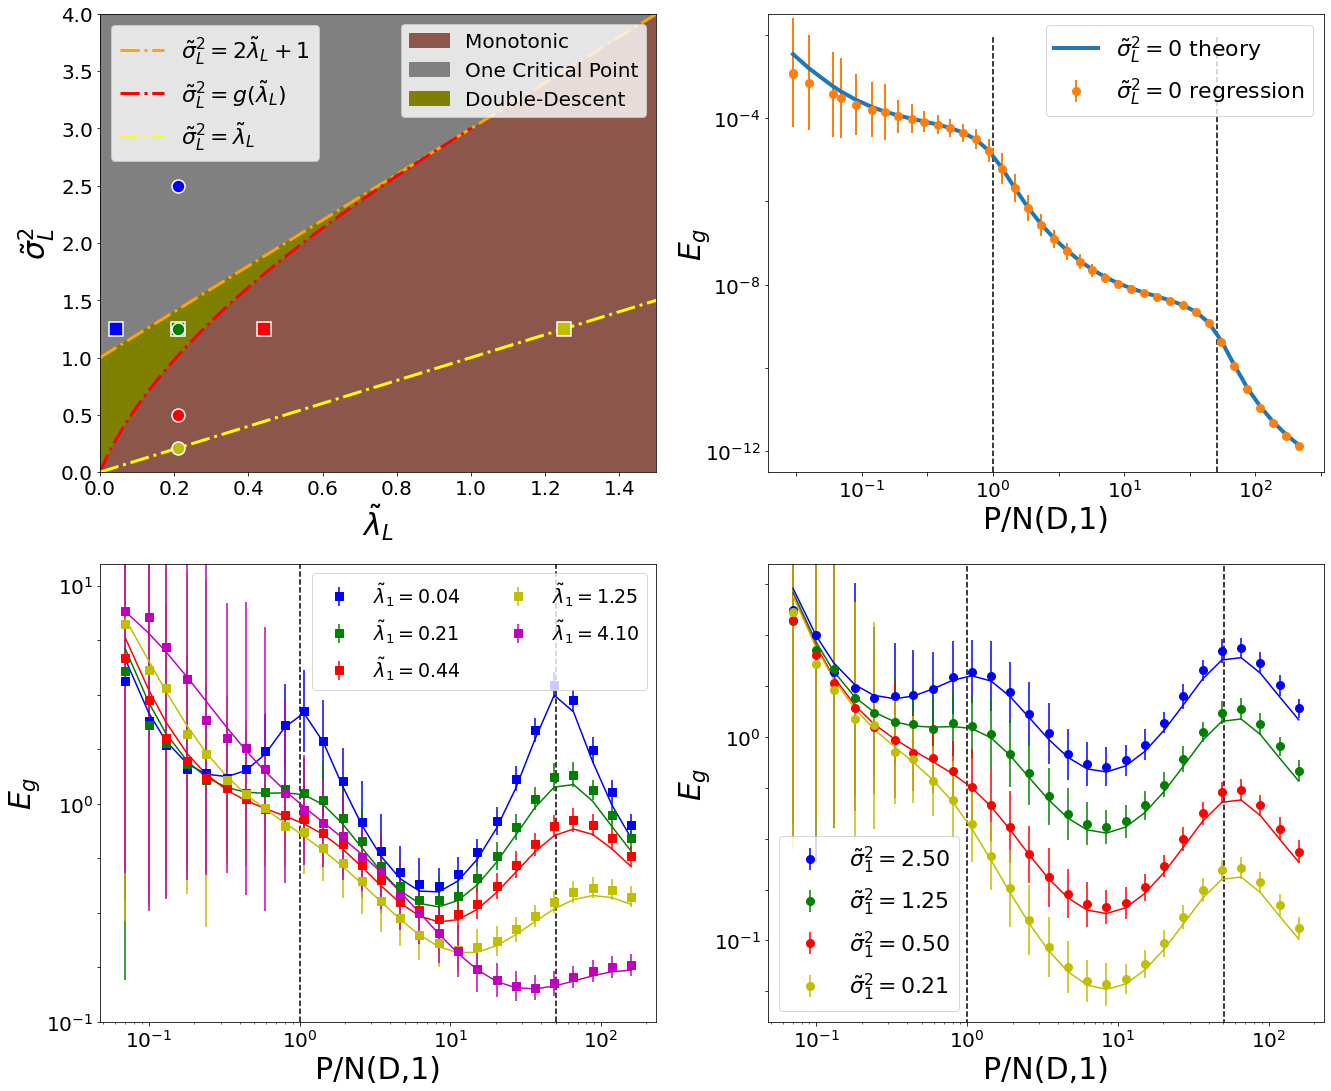

In [6]:
plt.rcParams.update({'font.size': 20})
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(17,14))
fontsize = '30'

cs = ax1.contourf(X, Y, Z, levels, colors=['tab:brown', 'grey','C7', 'olive'])
ax1.plot(lamb,2*lamb+1,'r-.',color='orange'
      ,linewidth='3',label='$\\tilde{\sigma}_{L}^2=2\\tilde{\\lambda}_{L}+1$')
ax1.plot(lamb[:cut],ker_sim.noise(lamb+1)[:cut],'-.',color='red'
         ,linewidth='3',label='$\\tilde{\sigma}_{L}^2=g(\\tilde{\\lambda}_{L})}$')
ax1.plot(lamb,lamb,'-.',color='yellow'
         ,linewidth='3',label='$\\tilde{\sigma}_{L}^2 = \\tilde{\\lambda}_{L} $')

ax1.set(xlim=(0, 1.5), ylim=(0, 4))
#ax1.vlines(alpha_a-1,0,4,linestyles='dashed')
#ax1.hlines(1.25,0,1.5,linestyles='dashed')
ax1.set_xlabel("$\\tilde{\\lambda}_{L}$",fontsize=fontsize)
ax1.set_ylabel("$\\tilde{\sigma}_{L}^2$",fontsize=fontsize)

proxy = []
pc = [cs.collections[0], cs.collections[1], cs.collections[3]]
for p in pc:
    proxy += [plt.Rectangle((0,0),1,1,color = p.get_facecolor()[0])]

leg1 = ax1.legend(loc='upper left',  ncol=1, fontsize = 22)
leg2 = ax1.legend(proxy, ["Monotonic", "One Critical Point", "Double-Descent"],loc='upper right')
ax1.add_artist(leg1)

colors = ['b', 'g', 'r', 'y', 'm', 'c',  'k']
n_idx = 3
for i in range(len(ker_var_alpha_n)):
    
    ax1.plot(alpha_n[i]-1,noise_var_tilde_n,'s',markersize = '14',
             markeredgewidth=1.5, markeredgecolor = 'w',color = colors[i])
    
    norm = spectrum_n[i,1]**2*degens_n[1]
    log_p = pvals_n[n_idx:]/degens_n[1]
    log_err_th = np.log10(errs_tot_n[i,n_idx:,0]/norm)
    log_err_exp = np.log10(all_errs_n[i, n_idx:]/norm)
    log_std_exp = all_stds_n[i, n_idx:]/all_errs_n[i, n_idx:]/np.sqrt(num_avg_n)#/all_errs_n[i, n_idx:]
    label_txt = '$\\tilde\lambda_1 = %0.2f$' % (alpha_n[i]-1)
    ax3.plot(log_p, log_err_th, color = colors[i]);
    ax3.errorbar(log_p, log_err_exp, log_std_exp, fmt = 's',markersize = '8', color = colors[i], label = label_txt)
    ax3.set_xscale('log')
    # ax3.set_yscale('log')
    ax3.set_xlabel('P/N(D,1)', fontsize = fontsize)
    ax3.set_ylabel('${E_g}$', rotation = 90, fontsize = fontsize)
    
    if i < 4:
        k = -i-1
        ax1.plot(alpha_a-1, noise_a[k],'o',markersize = '13',
             markeredgewidth=1.5, markeredgecolor = 'w',color = colors[i])

        norm = spectrum_a[1]**2*degens_a[1]
        log_p = (pvals_a[n_idx:]/degens_a[1])
        log_err_th = np.log10(errs_tot_a[0,n_idx:,k]/norm)
        log_err_exp = np.log10(all_errs_a[0, k, n_idx:]/norm)
        log_std_exp = all_stds_a[0, k, n_idx:]/all_errs_a[0, k, n_idx:]/np.sqrt(num_avg_a)#/all_errs_n[i, n_idx:]
        label_txt = '$\\tilde\sigma_1^2 = %0.2f$' % noise_a[k]
        ax4.plot(log_p, log_err_th, color = colors[i]);
        ax4.errorbar(log_p, log_err_exp, log_std_exp,  fmt = 'o',markersize = '8', color = colors[i], label = label_txt)
        ax4.set_xscale('log')
        #ax4.set_yscale('log')
        ax4.set_xlabel('P/N(D,1)', fontsize = fontsize)
        ax4.set_ylabel('${E_g}$', rotation = 90, fontsize = fontsize)
        ax4.yaxis.set_label_coords(-0.1,.52)


ax3.legend(loc='upper right',ncol = 2, fontsize = 19)
ax4.legend(ncol = 1, fontsize = 22)

## Put the degeneracy lines

ax3.set_ylim(-1,1.1)
ax3.vlines(1,-1,1.2,linestyle = 'dashed')
ax3.vlines(degens_a[2]/degens_a[1],-1,1.2,linestyle = 'dashed')
labels_y = ['$10^{-1}$','','','','$10^{0}$','','','','$10^1$','']
ax3.set_yticklabels(labels_y)


ax4.set_ylim(-1.4,0.85)
ax4.vlines(1,-2,1.2,linestyle = 'dashed')
ax4.vlines(degens_a[2]/degens_a[1],-2,1.2,linestyle = 'dashed')
labels_y = ['','','$10^{-1}$','','','','$10^{0}$','','','','$10^1$','']
ax4.set_yticklabels(labels_y)

## Finally noiseless case

ax2.plot(np.log10(pvals_o/degens_a[1]), np.log10(errs_tot_o[2,:,2]), linewidth = 4, label = '$\\tilde\sigma_L^2 = 0$ theory')
ax2.errorbar(np.log10(pvals_o/degens_a[1]), np.log10(all_errs_o[2,2]), all_stds_o[2,2]/all_errs_o[2,2]
             , fmt='o', markersize = 8, linewidth = 2, label = '$\\tilde\sigma_L^2 = 0$ regression')
labels_x = ['','','$10^{-1}$','','$10^{0}$','','$10^1$','','$10^2$'];
labels_y = ['$10^{-14}$','$10^{-12}$','','$10^{-8}$','','$10^{-4}$',''];
ax2.set_xticklabels(labels_x);
ax2.set_yticklabels(labels_y);
ax2.yaxis.set_label_coords(-0.1,.5)
ax2.set_xlabel('P/N(D,1)', fontsize = fontsize)
ax2.set_ylabel('${E_g}$', rotation = 90, fontsize = fontsize)
ax2.set_ylim(-12.5,-1.5)
ax2.vlines(np.log10(degens_a[1]/degens_a[1]),-12.5,-2,linestyle = 'dashed')
ax2.vlines(np.log10(degens_a[2]/degens_a[1]),-12.5,-2,linestyle = 'dashed')
ax2.legend(ncol = 1, fontsize = 22)

plt.subplots_adjust(left = 0, right = 1, top = 1, bottom = 0)
if save_data: plt.savefig(save_dir + 'gaussian_phase_exp'+'.pdf', bbox_inches = 'tight')

# Cluster Experiments

In [7]:
spectrum, degens, _ = ker_spec.get_gaussian_spectrum(ker_var_o, dist_var_o, kmax_o, dim_o)
lambda_bar = spectrum*degens
alpha_s = lamb_o + np.array([np.sum(lambda_bar[i+1:])/lambda_bar[i+1] for i in range(kmax_o-2)])

mode_len = 3
noise_len = 3
pvals_asymp = np.logspace(-2,8,50)
Errs_tot_asymp = np.zeros((mode_len, len(shift), len(pvals_asymp), noise_len))
for i in range(len(shift)):
    for j in range(mode_len): 
        Errs_tot_asymp[j, i] = ker_sim.simulate_asymptotic(pvals_asymp, spectrum, degens, noise_o[i], lamb=lamb_o, mode = j + 1)

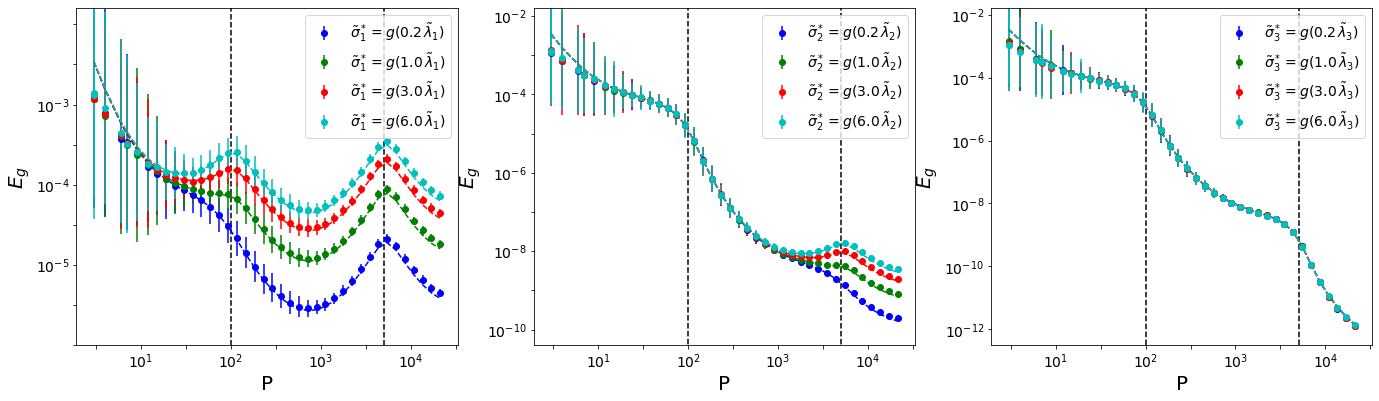

In [8]:
n_idx = 0

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)

kplot = [1, 2, 3,4]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for n_idx in range(3):
    all_errs_n = all_errs_o[:,n_idx]
    all_stds_n = all_stds_o[:,n_idx]

    errs_tot_n = errs_tot_o[:,:,n_idx]
    alpha_n = alpha[n_idx]
    for j in range(len(shift)):
        label_txt = '$\\tilde\sigma_{0}^*=g({1:.1f}\,\\tilde\lambda_{0})$'.format(n_idx+1, 1+shift[j])
        
        error_exp = all_errs_n[j,:]
        std_exp = all_stds_n[j,:]/np.sqrt(num_avg_o)
        alpha_s = alpha_n+shift[j]
        ax[n_idx].errorbar(np.log10(pvals_o), np.log10(error_exp), std_exp/error_exp, fmt = 'o', color=colors[j],label= label_txt)

        error_theory = errs_tot_n[j,:]
        ax[n_idx].plot(np.log10(pvals_o), np.log10(error_theory), '--', color=colors[j])

        ax[n_idx].set_xlabel(r'P', fontsize = 20)
        ax[n_idx].set_ylabel(r'$E_g$', fontsize = 20)
        ax[n_idx].legend()
        
labelsx0 = ['','','$10^{1}$','','$10^{2}$','','$10^{3}$','','$10^{4}$','']
labelsy0 = ['','','$10^{-5}$','','$10^{-4}$','','$10^{-3}$','']
labelsy1 = ['','$10^{-10}$','','$10^{-8}$','','$10^{-6}$','','$10^{-4}$','','$10^{-2}$','']
labelsy2 = ['','$10^{-12}$','$10^{-10}$','$10^{-8}$','$10^{-6}$','$10^{-4}$','$10^{-2}$','$10^{-0}$']
ax[0].set_xticklabels(labelsx0)
ax[1].set_xticklabels(labelsx0)
ax[2].set_xticklabels(labelsx0)
ax[0].set_yticklabels(labelsy0)
ax[1].set_yticklabels(labelsy1)
ax[2].set_yticklabels(labelsy2)

ax[0].set_ylim(-6,-1.8)
ax[0].vlines(np.log10(degens_a[1]),-7,-1.5,linestyle = 'dashed')
ax[0].vlines(np.log10(degens_a[2]),-7,-1.5,linestyle = 'dashed')

ax[1].set_ylim(-10.4,-1.8)
ax[1].vlines(np.log10(degens_a[1]),-12,-1.5,linestyle = 'dashed')
ax[1].vlines(np.log10(degens_a[2]),-12,-1.5,linestyle = 'dashed')

ax[2].set_ylim(-12.5,-1.8)
ax[2].vlines(np.log10(degens_a[1]),-13,-1.5,linestyle = 'dashed')
ax[2].vlines(np.log10(degens_a[2]),-13,-1.5,linestyle = 'dashed')

plt.subplots_adjust(bottom=0.02, right=0.95, top=0.8, left=-0.25)
fig.set

if save_data: plt.savefig(save_dir + 'gaussian_different_stages.pdf', bbox_inches = 'tight');

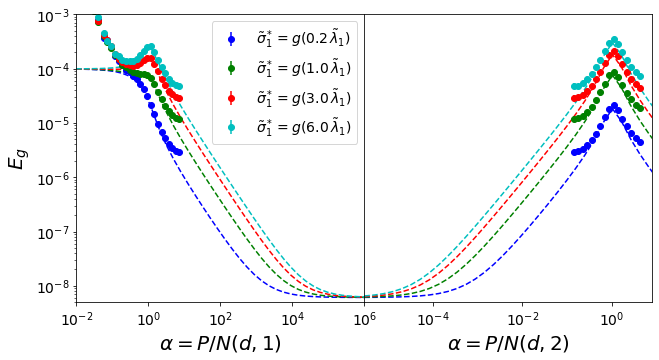

In [9]:
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1, 2)
plt.subplots_adjust(bottom=0, top = 0.8, left = 0, right =2, wspace=0)
fig.set_size_inches(7, 4)

for i in range(len(axs)):
    axs[i].set_ylim(5e-9, 1e-3)
    axs[i].axes.get_yaxis().set_visible(False)

axs[0].axes.get_yaxis().set_visible(True)
axs[0].axes.set_ylabel('$E_g^{(l)}(\\alpha)$')

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

n = 0
all_errs_n = all_errs_o[:,n]
all_stds_n = all_stds_o[:,n]
errs_tot_n = errs_tot_o[:,:,n]

n_idx = 0
cut = 25
alpha_n = alpha[n_idx]
axs[n_idx].set_xlim(1e-2, 1e+6) 
for j in range(len(shift)):
    label_txt = '$\\tilde\sigma_{0}^*=g({1:.1f}\,\\tilde\lambda_{0})$'.format(n_idx+1, 1+shift[j])

    error_exp = all_errs_n[j,:]
    std_exp = all_stds_n[j,:]/np.sqrt(num_avg_o)
    alpha_s = alpha_n+shift[j]
    
    p_vals = pvals_o[:cut]/degens_n[n_idx+1]
    exp_error = error_exp[:cut]
    exp_std = std_exp[:cut]

    axs[n_idx].errorbar(p_vals, exp_error, exp_std*0, fmt = 'o', color=colors[j],label=label_txt)

    error_theory = Errs_tot_asymp[n_idx, j,:, n]
    
    axs[n_idx].plot(pvals_asymp/degens[n_idx+1], error_theory, '--', color=colors[j])

    axs[n_idx].set_xscale('log')
    axs[n_idx].set_yscale('log')
    k = n_idx + 1
    axs[n_idx].set_xlabel('$\\alpha = P/N(d,%d)$'  % k, fontsize = 20)  
    
n_idx = 1
cut = pvals_o.size - cut+9
alpha_n = alpha[n_idx]
axs[n_idx].set_xlim(3e-6, 8)  
for j in range(len(shift)):
    label_txt = '$\\tilde\sigma_{0}^*=g({1:.1f}\,\\tilde\lambda_{0})$'.format(n_idx+1, 1+shift[j])

    error_exp = all_errs_n[j,:]
    std_exp = all_stds_n[j,:]/np.sqrt(num_avg_o)
    alpha_s = alpha_n+shift[j]
    
    p_vals = pvals_o[cut:]/degens[n_idx+1]
    exp_error = error_exp[cut:]
    exp_std = std_exp[cut:]

    axs[n_idx].errorbar(p_vals, exp_error, exp_std, fmt = 'o', color=colors[j],label=label_txt)

    error_theory = Errs_tot_asymp[n_idx, j,:, n]
    
    axs[n_idx].plot(pvals_asymp/degens[n_idx+1], error_theory, '--', color=colors[j])

    axs[n_idx].set_xscale('log')
    axs[n_idx].set_yscale('log')
    k = n_idx + 1
    axs[n_idx].set_xlabel('$\\alpha = P/N(d,%d)$'  % k, fontsize = 20)  

axs[0].set_ylabel(r'$E_g$', fontsize = 20)
axs[0].legend()


fig.set_figheight(5)
fig.set_figwidth(4)
fig.set

if save_data: plt.savefig(save_dir + 'gaussian_asymptotic.pdf', bbox_inches = 'tight');